# Compare the Sizes of Data Files
Show the effect of different compression settings on file size

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

Configuration

## Load Results
Load the results from previous tests

In [2]:
results = pd.read_json('storage-results.json', lines=True)
results['bytes_per_row'] = results['size'] / results['rows']

Assign a "None" value to missing compression_sizes

In [3]:
results.loc[results['compression_level'].isnull(), 'compression_level'] = 0

Assign a label to each type of test

In [4]:
results['float_size'] = results['schema'].apply(lambda x: x['Current_A'])

In [5]:
results['test_id'] = None
for i, (_, group) in enumerate(results.groupby(['float_size', 'compression', 'compression_level'])):
    results.loc[group.index, 'test_id'] = i

## Effect of Float Size
See how the storage size is affected by float size

In [6]:
no_compression = results.query('compression == "NONE"')
no_compression

,rows,columns,schema,compression,size,compression_level,bytes_per_row,float_size,test_id
8,1000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'uint16', 'Voltage_V': 'uint16',...",NONE,16764,0.0,16.764000,uint16,10
9,3000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'uint16', 'Voltage_V': 'uint16',...",NONE,45425,0.0,15.141667,uint16,10
10,10000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'uint16', 'Voltage_V': 'uint16',...",NONE,138520,0.0,13.852000,uint16,10
11,30000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'uint16', 'Voltage_V': 'uint16',...",NONE,392147,0.0,13.071567,uint16,10
24,1000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'uint32', 'Voltage_V': 'uint32',...",NONE,17524,0.0,17.524000,uint32,14
25,3000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'uint32', 'Voltage_V': 'uint32',...",NONE,47626,0.0,15.875333,uint32,14
26,10000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'uint32', 'Voltage_V': 'uint32',...",NONE,145449,0.0,14.544900,uint32,14
27,30000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'uint32', 'Voltage_V': 'uint32',...",NONE,415312,0.0,13.843733,uint32,14
40,1000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'float', 'Voltage_V': 'float', '...",NONE,17244,0.0,17.244000,float,6
41,3000,"[Current_A, Voltage_V, Cell_Temperature_C, Dat...","{'Current_A': 'float', 'Voltage_V': 'float', '...",NONE,47346,0.0,15.782000,float,6


Text(0, 0.5, 'Cost (Bytes/row)')

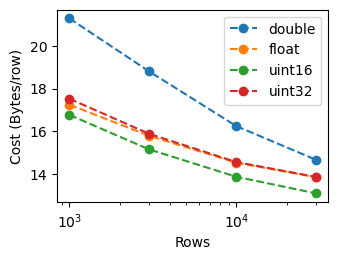

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for gid, group in no_compression.groupby('float_size'):
    group = group.groupby('rows')['bytes_per_row'].min()
    ax.semilogx(group.index, group.values, '--o', label=gid)


ax.legend()

ax.set_xlabel('Rows')
ax.set_ylabel('Cost (Bytes/row)')

Single precision doesn't save us _much_, given that part of the storage cost is driven by datetime signature

## Effect of Compression
Large files should compress better, to a point.

In [8]:
no_compression = results.query('compression == "NONE"')

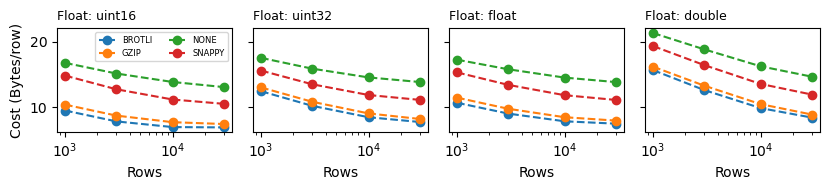

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(8.4, 2.), sharey=True)

for ax, float_size in zip(axs, ['uint16', 'uint32', 'float', 'double']):
    subset = results.query(f'float_size == "{float_size}"')
    ax.set_title(f'Float: {float_size}', loc='left', fontsize=9)
    for gid, group in subset.groupby('compression'):
        group = group.groupby('rows')['bytes_per_row'].min()
        ax.semilogx(group.index, group, '--o', label=gid)

    ax.set_xlabel('Rows')
axs[0].legend(fontsize=6, ncol=2)
axs[0].set_ylabel('Cost (Bytes/row)')
fig.tight_layout()

fig.savefig('summary.png', dpi=320)

We can get to sub 10 bytes/row when compressing with BROTLI whether we store in full compression or not and as low as 5 bytes per row with storing as int